# Job Shop Scheduling: Heuristics

In the previous [tutorial on Job Shop Scheduling: Basics and State Space Search](https://homepages.ecs.vuw.ac.nz/~yimei/tutorials/job-shop-scheduling-state-space-search.html), we have introduced the basics of **job shop scheduling** and an AI planning **state space search** algorithm to find the best schedule with the minimal makespan.

The state space search algorithm searches all the possible goal states (schedules) exhaustively. Although the exhaustive search can guarantee optimality, its **computation complexity grows exponentially with the increase of the problem size**. 

> The computational complexity of the state space exhaustive search is $O(N^{NM})$, where $N$ is the number of jobs and $M$ is the number of machines.

Therefore, it is usually not possible to enumerate all the possible solutions / goal states to find the optimal solution.

> The job shop scheduling problem is known as $\mathbb{NP}$-hard, which means there is no exact method that can find the optimal schedule in polynomial time.

As the problem size increases, it is impossible to enumerate all the possible solutions. In this case, we can develop **heuristic search** approaches to search **ONLY a part** of the solution space, to find **good enough** solutions within **a reasonable time**. 

In this tutorial, we introduce the heuristic search approaches for job shop scheduling, including the **dispatching rule** and **local search**.

# Table of Contents

1. [General Heuristic Search Framework](#framework)
2. [Dispatching Rule](#rule)
3. [Local Search](#ls)

---------

## 1. General Heuristic Search Framework <a name='framework'></a>


As described in the previous [tutorial](https://homepages.ecs.vuw.ac.nz/~yimei/tutorials/job-shop-scheduling-state-space-search.html), the pseudo code of the **exhaustive state space search** for job shop scheduling is given as follows.

---------

```python
Generate an initial state, best_state = None, best_makespan = infinity
# Initialise the fringe with the initial state
fringe = [initial_state]

# Search by expanding a branch at each step
while fringe is not empty:
    Pick a state from fringe
    
    if state is a goal state:
        if state.schedule has a smaller makespan than best_makespan:
            best_state = state, best_makespan = makespan
    
    Find the applicable actions at state
    
    for action in applicable_actions:
        Apply action to state to generate next_state
        Add next_state into fringe

    remove state from fringe
return best_state.schedule
```

-------------

It **enumerates** all the possible solutions by 

1. Expand the branches of **ALL** the applicable actions at each state during the search;
2. Stop the search after **ALL** the goal states have been visited.

As the problem size increases, it is impossible to enumerate all the possible solutions. In this case, we develop heuristic search approaches to search **a part** of the solution space, to find **good enough** solutions within **a reasonable time**. 

Generally speaking, the heuristic search approaches are based on pruning the search space by ignoring the branches that are unlikely to reach promising/optimal solutions. This is also known as the **beam search**. The pruning can be done by modifying the above pseudo code as follows.

1. Expand the branches of **only a subset** of the applicable actions at each state;
2. **Early stop** the search.
3. Note that the state space search picks states from the fringe arbitrarily. To further improve the search efficiency, we can design heuristics to pick the **best state** first, so we can expand the better branches first and stop the search earlier.

Taking the above factors into account, the **heuristic search** in the state space can be written as follows.

---------

```python
Generate an initial state, best_state = None, best_makespan = infinity
# Initialise the fringe with the initial state
fringe = [initial_state]

# Search by expanding a branch at each step
while fringe is not empty:
    Heuristic select a state from fringe
    
    if state is a goal state:
        if state.schedule has a smaller makespan than best_makespan:
            best_state = state, best_makespan = makespan
        if early stop:
            return best_state.schedule
    
    Find the applicable actions at state
    
    for action in subset(applicable_actions):
        Apply action to state to generate next_state
        Add next_state into fringe

    remove state from fringe
return best_state.schedule
```

-------------

In this heuristic search, there are three design issues:

1. The heuristic to select the next state from the fringe to expand.
2. The subset `subset(applicable_actions)` that selects the subset of the applicable actions to expand.
3. The early stopping criterion.

Below we introduce some common design of the heuristics.

-------------

## 2. Dispatching Rule <a name='rule'></a>

Dispatching rule is a very simple heuristic that expands **only one** action at each state. Therefore, starting with a single initial state, the fringe always contains a single state. Thus, at each step we trivially select the only state in the fringe. As a result, only a single goal state will be reached. Thus, The stopping criterion is also trivial: the search will stop after the first and only goal state is reached.

For example, if we are given the following state space to be searched in:

<img src="img/jss-state-search.png" width=600 /> 

The search based on dispatching rule will select one branch (highlighted in blue boxes) at each state and finally reach a single goal state (a leaf node in the search tree).

<img src="img/jss-rule-search.png" width=600 />

A dispatching rule selects the single action from the applicable actions based on the following two steps.

1. Select the **earliest** applicable action (with the smallest start time).
2. If there are multiple earliest applicable actions, then select an action based on the predefined **priority function**. Specifically, for each earliest applicable actions, a priority value in the current state is calculated by the priority function. Then, the action with the **highest priority** is selected.

The heuristic search based on dispatching rule can be written as follows.

---------

```python
Generate an initial state
# Initialise the fringe with the initial state
fringe = [initial_state]

# Search process, the fringe will become empty after the first and only goal state is reached
while fringe is not empty:
    # Select the first and only state in the fringe
    state = fringe[0]
    
    if state is a goal state:
        return state.schedule
    
    Find the applicable actions at state
    
    # Select the earliest action with the highest priority
    best_action = None, earliest_time = float('inf'), best_priority = -float('inf')
    for action in applicable_actions:
        if action.time < earliest_time:
            best_action = action, earliest_time = action.time, best_priority = priority(action, state)
        elif action.time == earliest_time:  
            p = priority(action, state)
            if p > best_priority:
                best_action = action, best_priority = p
    
    Apply best_action to state to generate next_state
    Add next_state into fringe

    remove state from fringe
```

-------------

> Dispatching rule has a promising characteristic that it always expends an earliest action. Taking advantage of this characteristic, we can convert the above procedure into a much more efficient **discrete event simulation** procedure with priority queue.

Below are some examples of commonly used dispatching rules.

- **First-Come-First-Serve (FCFS)**: it processes the operation that comes to the machine (becomes ready) first. The priority function can be defined as the negative ready time of the processed operation, i.e., `priority(action, state) = - state.operation_ready_time[action.operation]`.
- **Shortest-Processing-Time (SPT)**: it processes the shortest operation with the smallest processing time first. The priority function can be defined as the negative processing time, i.e., `priority(action, state) = - action.operation.duration`.

### Computational Complexity

Assume that there are $N$ jobs and $M$ machines. Each job has $M$ operations, each to be processed by a different machine. There are $NM$ operations in total.

At each state, there can be at most $N$ applicable actions, as each job can have an operation ready. Therefore, it takes $O(N)$ time to find the best action from the $N$ applicable actions. However, only one branch is expanded.

Each action completes an operation. Thus, it takes $NM$ actions from the initial state to a goal state. In other words, the depth of the tree is $NM$.

In summary, a dispatching rule generates a chain-like search tree where each node has only one branch expanded. The entire search process visits $NM$ states, where each state takes $O(N)$ time to find the expanded branch. Therefore, the overall complexity of the dispatching rule-based heuristic search is $O(N^2M)$.

> If the procedure is implemented by a **discrete event simulation**, for each state, we can obtain the earliest applicable actions in $O(1)$ time. In this case, we can find the best branch in $O(E)$ time, where $E$ is the number of earliest applicable action, which is usually much smaller than $N$. We can see that the **discrete event simulation** can greatly reduce the computational complexity to $O(NME) \ll O(N^2M)$.



### Case Study on Car Manufacturing

Below is a case study of the heuristic search based on dispatching rule on the car manufacturing example. To this end we need to prepare the supporting Python classes and utility methods. These include

- The classes for the job shop environment: `Operation`, `Job` and `JobShop`.
- The classes for the state space search: `State` and `Process` action.
- The utility methods: finding applicable actions of a state, makespan calculation, and schedule display.


First, we define the Python classes for `Operation`, `Job` and `JobShop` as below.

In [1]:
class Operation:
    '''
    Construct an operation, including the following properties.
    - name of the operation
    - machine
    - duration (processing time)
    - prec (preceding operation)
    - succ (succeeding operation)
    '''
    def __init__(self, name, machine, duration, prec, succ):
        self.name = name
        self.machine = machine
        self.duration = duration
        self.prec = prec
        self.succ = succ
        
class Job:
    '''
    Construct a job, including the following properties.
    - job name
    - list of operations
    - arrival time, default to be 0
    - due date, default to be infinity
    - weight, default to be 1
    '''
    def __init__(self, name, operations):
        self.name = name
        self.operations = operations
        self.arrival_time = 0
        self.due_date = float('inf')
        self.weight = 1
        
class JobShop:
    '''
    Construct a job shop environment, including a list of machines and a list of jobs.
    '''
    def __init__(self, machines, jobs):        
        self.machines = machines
        self.jobs = jobs
        
        # We also create a hash map to quickly access operations if needed
        self.operations = {}
        for job in jobs:
            for op in job.operations:
                self.operations[op.name] = op

Then, we define the Python classes for the `State` and `Process` action for state space search as follows.

In [2]:
class State:
    '''
    Initialise the state with the job shop, i.e., a list of machines and a list of operations.
    '''
    def __init__(self, job_shop):
        # 1. Initially, the idle time of all the machines are 0.
        self.machine_idle_time = {}
        for machine in job_shop.machines:
            self.machine_idle_time[machine] = 0 
        
        # 2. Initially, all the operations except the first operations of the jobs are not ready.
        # Their ready time are undefined, so not added into the operation_ready_time.
        self.operation_ready_time = {}
        for job in job_shop.jobs:
            self.operation_ready_time[job.operations[0].name] = job.arrival_time
        
        # 3. Initial schedule is empty
        self.schedule = []
        
        # 4. Initially, no operation is completed, and the list is empty.
        self.completed = []

import copy

class Process:
    '''
    Construct a process with an operation, a machine and a time
    '''
    def __init__(self, operation, machine, time):
        self.operation = operation
        self.machine = machine
        self.time = time
    
    '''
    Check its precondition to see if it is applicable in a state.
    '''
    def is_applicable(self, state):
        # Check if the operation is completed or not.
        if self.operation.name in state.completed:
            return False
        
        # Check if the operation is ready now or not.
        if state.operation_ready_time[self.operation.name] > self.time:
            return False
        
        # Check if the machine is idle now or not.
        if state.machine_idle_time[self.machine] > self.time:
            return False

        return True
    
    '''
    Apply the processing action to a state, and return the resultant state.
    '''
    def apply(self, state):
        new_state = copy.deepcopy(state)
        
        # Add this process action to the schedule
        new_state.schedule.append(self)
        
        # The operation becomes completed
        new_state.completed.append(self.operation.name)
        
        # Delete the operation from operation_ready_time, since it is completed
        new_state.operation_ready_time.pop(self.operation.name)
        
        completion_time = self.time + self.operation.duration
        
        # The machine becomes busy, and will be idle again after the operation is completed
        new_state.machine_idle_time[self.machine] = completion_time
        
        # If the operation is not the last operation of the job, then its next operation becomes ready
        if self.operation.succ != None:
            new_state.operation_ready_time[self.operation.succ.name] = completion_time
        
        return new_state

Below we define the following utility methods.

- `applicable_actions()`: find the applicable actions for a `state` in a `job_shop` environment.
- `makespan()`: calculate the makespan of a `schedule`.

In [3]:
def applicable_actions(state, job_shop):
    actions = []
    
    # Enumerate all the operations in the operation_ready_time map.
    # For efficiency, this map ignores the operations whose ready time are still infinity 
    # (they are not applicable anyway).
    for opname in state.operation_ready_time.keys():
        op = job_shop.operations[opname]
        
        time = state.operation_ready_time[opname]
        
        if time < state.machine_idle_time[op.machine]:
            time = state.machine_idle_time[op.machine]
            
        action = Process(op, op.machine, time)
        
        if action.is_applicable(state):
            actions.append(action)
    
    return actions

def makespan(schedule):
    makespan = 0
    
    for action in schedule:
        completion_time = action.time + action.operation.duration
        
        if completion_time > makespan:
            makespan = completion_time
    
    return makespan

Then, we install the `matplotlib` library and define methods for visualising a schedule by gantt chart as follows.

In [4]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# Convert a schedule to a Pandas data frame
def schedule_data_frame(schedule):
    # Convert each action to dictionary
    schedule_dict = []
    for action in schedule:
        a_dict = {
            'Operation': action.operation.name,
            'Machine': action.machine,
            'Start': action.time,
            'Duration': action.operation.duration,
            'Finish': action.time + action.operation.duration
        }
        schedule_dict.append(a_dict)
    
    return pd.DataFrame(schedule_dict)

# Visualise a schedule by gantt chart
def visualise(schedule):
    schedule = schedule_data_frame(schedule)
    
    JOBS = sorted(list(schedule['Operation'].unique()))
    MACHINES = sorted(list(schedule['Machine'].unique()))
    makespan = schedule['Finish'].max()
    
    bar_style = {'alpha':1.0, 'lw':25, 'solid_capstyle':'butt'}
    text_style = {'color':'white', 'weight':'bold', 'ha':'center', 'va':'center'}
    colors = mpl.cm.Dark2.colors

    schedule.sort_values(by=['Operation', 'Start'])
    schedule.set_index(['Operation', 'Machine'], inplace=True)

    fig, ax = plt.subplots(2,1, figsize=(12, 5+(len(JOBS)+len(MACHINES))/4))

    for jdx, j in enumerate(JOBS, 1):
        for mdx, m in enumerate(MACHINES, 1):
            if (j,m) in schedule.index:
                xs = schedule.loc[(j,m), 'Start']
                xf = schedule.loc[(j,m), 'Finish']
                ax[0].plot([xs, xf], [jdx]*2, c=colors[mdx%7], **bar_style)
                ax[0].text((xs + xf)/2, jdx, m, **text_style)
                ax[1].plot([xs, xf], [mdx]*2, c=colors[jdx%7], **bar_style)
                ax[1].text((xs + xf)/2, mdx, j, **text_style)
                
    ax[0].set_title('Job Schedule')
    ax[0].set_ylabel('Operation')
    ax[1].set_title('Machine Schedule')
    ax[1].set_ylabel('Machine')
    
    for idx, s in enumerate([JOBS, MACHINES]):
        ax[idx].set_ylim(0.5, len(s) + 0.5)
        ax[idx].set_yticks(range(1, 1 + len(s)))
        ax[idx].set_yticklabels(s)
        ax[idx].text(makespan, ax[idx].get_ylim()[0]-0.2, "{0:0.1f}".format(makespan), ha='center', va='top')
        ax[idx].plot([makespan]*2, ax[idx].get_ylim(), 'r--')
        ax[idx].set_xlabel('Time')
        ax[idx].grid(True)
        
    fig.tight_layout()

After defining all the above supporting classes and utility methods, we define the core `heuristic_search_dispatching_rule()` method as follows. It takes the `priority` function as an argument, which varies depending on the dispatching rule used.

In [6]:
def heuristic_search_dispatching_rule(job_shop, priority):
    # Initialise the state and fringe
    init_state = State(job_shop)
    fringe = [init_state]
    
    while len(fringe) > 0:
        state = fringe[0] # select the first and only state in the fringe
        
        if len(state.completed) == len(job_shop.operations):
            return state.schedule
        
        actions = applicable_actions(state, job_shop)
        
        best_action = None
        earliest_time = float('inf')
        best_priority = -float('inf')
        for a in actions:
            if a.time < earliest_time:
                best_action = a
                earliest_time = a.time
                best_priority = priority(a, state)
            elif a.time == earliest_time:
                p = priority(a, state)
                if p > best_priority:
                    best_action = a
                    best_priority = p
        
        next_state = best_action.apply(state)
        fringe.append(next_state)
        
        fringe.remove(state)

Now, we create a car manufacturing example as follows. It contains three jobs, each with three operations [`add_engine`, `add_wheels`, `inspect`]. The first two jobs is arrived at the beginning (time 0), while the third job arrives at time 10.

| Job | Arrival | Operation | Machine | Duration |
| --- | --------- | ------- | --------- | --------- |
| 1   | 0 | `add_engine_1` | `engine_hoist` | 30 |
|     |   | `add_wheels_1` | `wheel_station` | 30 |
|     |   | `inspect_1` |    `inspector` | 10 |
| 2   | 0 | `add_engine_2` | `engine_hoist` | 60 |
|     |   | `add_wheels_2` | `wheel_station` | 15 |
|     |   | `inspect_2` |    `inspector` | 10 |
| 3   | 10| `add_engine_3` | `engine_hoist` | 20 |
|     |   | `add_wheels_3` | `wheel_station` | 30 |
|     |   | `inspect_3` |    `inspector` | 10 |

In [7]:
machines = ['engine_hoist', 'wheel_station', 'inspector']

add_engine_1 = Operation('add_engine_1', 'engine_hoist', 30, None, None)
add_wheels_1 = Operation('add_wheels_1', 'wheel_station', 30, add_engine_1, None)
inspect_1 = Operation('inspect_1', 'inspector', 10, add_wheels_1, None)
add_engine_2 = Operation('add_engine_2', 'engine_hoist', 60, None, None)
add_wheels_2 = Operation('add_wheels_2', 'wheel_station', 15, add_engine_2, None)
inspect_2 = Operation('inspect_2', 'inspector', 10, add_wheels_2, None)
add_engine_3 = Operation('add_engine_3', 'engine_hoist', 20, None, None)
add_wheels_3 = Operation('add_wheels_3', 'wheel_station', 30, add_engine_3, None)
inspect_3 = Operation('inspect_3', 'inspector', 10, add_wheels_3, None)

add_engine_1.succ = add_wheels_1
add_wheels_1.succ = inspect_1
add_engine_2.succ = add_wheels_2
add_wheels_2.succ = inspect_2
add_engine_3.succ = add_wheels_3
add_wheels_3.succ = inspect_3

job_1 = Job('job_1', [add_engine_1, add_wheels_1, inspect_1])
job_2 = Job('job_2', [add_engine_2, add_wheels_2, inspect_2])
job_3 = Job('job_3', [add_engine_3, add_wheels_3, inspect_3])
job_3.arrival_time = 10

job_shop = JobShop(machines, [job_1, job_2, job_3])

Below we show the gantt chart of the schedule obtained by the heuristic search with the **Shortest Processing Time** rule, whose priority function is `- action.operation.duration`.

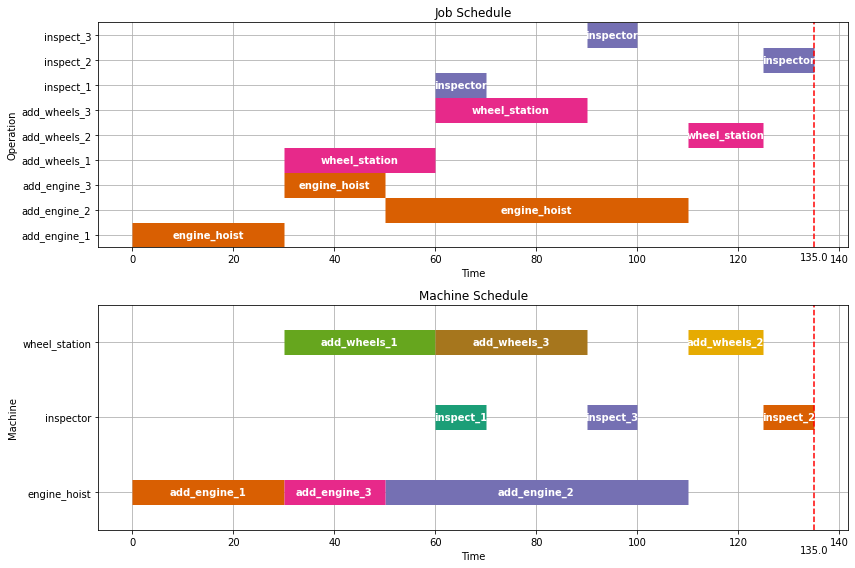

In [8]:
spt_rule = lambda action, state: -action.operation.duration

spt_schedule = heuristic_search_dispatching_rule(job_shop, spt_rule)
visualise(spt_schedule)

Below we show the gantt chart of the schedule obtained by the heuristic search with the **First Come First Serve** rule, whose priority function is `- operation ready time`. We can see the schedule is different from (worse than) the schedule obtained by the Shortest Processing Time rule.

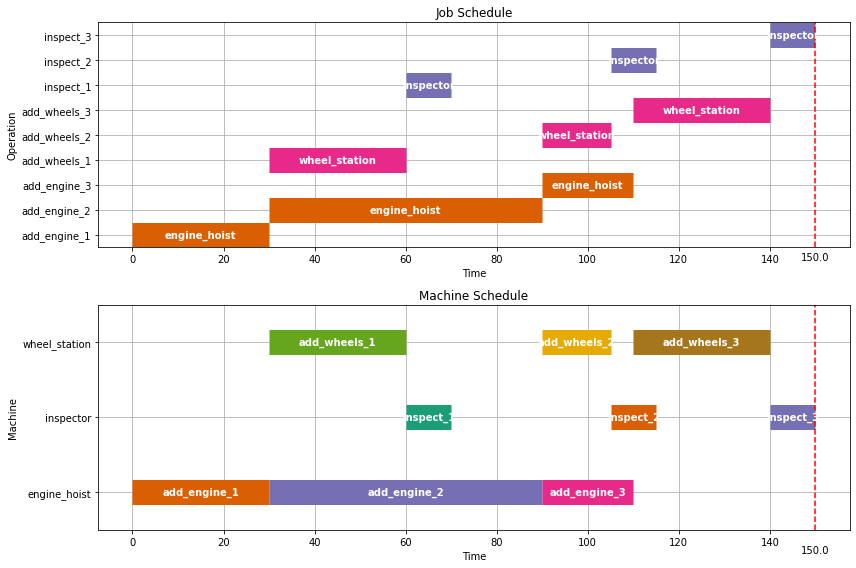

In [9]:
fcfs_rule = lambda action, state: -state.operation_ready_time[action.operation.name]

fcfs_schedule = heuristic_search_dispatching_rule(job_shop, fcfs_rule)
visualise(fcfs_schedule)

In comparison, we can see that the Shortest Processing Time rule processes `job_3` before `job_2`, since its first operation `add_engine_3` is shorter than `add_engine_2` when the `engine_hoist` machine becomes ready at time 30. However, the First Come First Serve rule processes `add_engine_2` before `add_engine_3` at time 30, since `job_2` arrives earlier than `job_3`. The long `add_engine_2` causes delay of the subsequent operations, and ultimately leads to larger makespan of the schedule.

--------

## 3. Local Search <a name='ls'></a> 

Most states in the state space are not goal states, i.e., they correspond to incomplete schedules. Local search can search among the **goal states only**, which leads to a much smaller search space than the state space.

### Solution/Schedule Representation

A complete schedule can be represented as a list of process actions `Process[operation, machine, time]` for each operation. In other words, it specifies the start time to process each operation subject to the *resource constraint* (each machine can process at most one operation at a time) and *precedence constraint* (an operation cannot start processing until its precedent operation is completed).

### Initial Solution/Schedule

We can randomly generate an initial schedule. We can follow the state space search framework, start from the initial state, and randomly select an action at each state until we reach a goal state.

Alternatively, we can also use a dispatching rule (e.g., First Come First Serve, Shortest Processing Time) to generate an initial schedule.

### Neighbourhood

The neighbourhood of a solution/schedule is defined by a **move operator** $\mathtt{op}$, such as swapping the order of two process actions on the same machine. Given a move operator $\mathtt{op}$, the corresponding neighbourhood of a solution is the set of all the possible solutions that can be generated by applying the operator to the current solution, i.e.,

$$
\mathcal{N}^{(\mathtt{op})}(S) = \{S' | S' = \mathtt{op}(S)\}.
$$

For example, given the following solution for car manufacturing:

| Machine |  Process Operation Order  |
| ------- | --------------  |
| `engine_hoist` | `add_engine_1` $\rightarrow$ `add_engine_2` $\rightarrow$ `add_engine_3` |
| `wheel_stateion` | `add_wheels_1` $\rightarrow$ `add_wheels_2` $\rightarrow$ `add_wheels_3` |
| `inspector` | `inspect_1` $\rightarrow$ `inspect_2` $\rightarrow$ `inspect_3` |

There are 3 possible swaps for each machine. For example, for `engine_hoist`, we have the following three swaps:

- (`add_engine_1`, `add_engine_2`), 
- (`add_engine_1`, `add_engine_3`), 
- (`add_engine_2`, `add_engine_3`). 

Therefore, there are $3 \times 3 \times 3 = 27$ possible neighbours in the neighbourhood by the swap operator. 

Note that for each neighouring solution, we need to **re-calculate the starting time** of the process actions. To this end, we modify the state space search to generate a schedule guided by the order of the solution, i.e., the order of operations by each machine. Specifically, we add an **additional precedence constraint** specified by the order of operations in the solution.

Below is the modified state space search to generate the schedule guided by the solution. Initially, the first operation in each machine sequence of the solution is ready. During the search, after getting the applicable actions, it further checks which applicable actions are processing the ready operation specified by the solution. Then, after processing each operation, the next operation in its machine sequence of the solution becomes ready.

In [10]:
def schedule_from_solution(job_shop, solution):
    # Initialise the state and fringe
    init_state = State(job_shop)
    fringe = [init_state]

    # The current ready operations from the solution, initially the first operations are ready
    solution_ready_op_idx = {}
    for machine in solution.op_sequences.keys():
        solution_ready_op_idx[machine] = 0
    
    while len(fringe) > 0:
        state = fringe[0] # select the first and only state in the fringe
        
        if len(state.completed) == len(job_shop.operations):
            return state.schedule
        
        actions = applicable_actions(state, job_shop)
        
        # Check if each action is processing the ready operation specified by the solution
        ready_actions = []
        for a in actions:
            solution_op = solution.op_sequences[a.machine][solution_ready_op_idx[a.machine]]
            if a.operation.name == solution_op.name:
                ready_actions.append(a)
        
        # Apply the next actions for each machine simultaneously
        next_state = state
        for a in ready_actions:
            # The next operation in the machine sequence becomes ready
            solution_ready_op_idx[a.machine] = solution_ready_op_idx[a.machine] + 1
            next_state = a.apply(next_state)
        
        fringe.append(next_state)
        fringe.remove(state)

We define the Python class for `solution` as follows.

In [11]:
import random

class Solution:
    '''
    Initialise a solution from a job shop.
    It simply places the operations to its corresponding machine sequences.
    '''
    def __init__(self, job_shop):
        self.op_sequences = {}
        for machine in job_shop.machines:
            self.op_sequences[machine] = []
        
        for job in job_shop.jobs:
            for op in job.operations:
                self.op_sequences[op.machine].append(op)
    
    '''
    Randomly shuffle the machine sequences with a random seed. This is for randomly generating a solution.
    '''
    def shuffle(self, seed):
        # Randomly shuffle the sequence of each machine
        random.seed(seed)
        for machine in job_shop.machines:
            random.shuffle(self.op_sequences[machine])

Then, we can design the local search (hill climbing) method based on swapping two operations on the same machine. The Python code of the local search is given as follows.

In [12]:
def local_search(solution, job_shop):
    # Get the schedule and makespan of the initial solution
    schedule = schedule_from_solution(job_shop, solution)
    mk = makespan(schedule)
    
    improved = True
    while(improved):
        improved = False
        
        # Enumerate the neighbours and find the best neighbour
        best_neighbour = None
        best_nb_schedule = None
        best_nb_mk = float('inf')
        
        for machine in job_shop.machines:
            machine_seq = solution.op_sequences[machine]
            
            for i in range(len(machine_seq)-1):
                for j in range(i+1, len(machine_seq)):
                    neighbour = copy.deepcopy(solution)
                    neighbour.op_sequences[machine][i] = machine_seq[j]
                    neighbour.op_sequences[machine][j] = machine_seq[i]
                    
                    nb_schedule = schedule_from_solution(job_shop, neighbour)
                    nb_mk = makespan(nb_schedule)
                    
                    if nb_mk < best_nb_mk:
                        best_neighbour = neighbour
                        best_nb_schedule = nb_schedule
                        best_nb_mk = nb_mk
        
        # Check if the best neighbour is better than the current solution
        if best_nb_mk < mk:
            improved = True
            solution = best_neighbour
            schedule = best_nb_schedule
            mk = best_nb_mk   
    
    return schedule

### Computational Complexity

Assume that there are $N$ jobs and $M$ machines. Each job has $M$ operations, each to be processed by a different machine. There are $NM$ operations in total.

At each step of the local search, we need to explore $O(MN^2)$ neighbours generated by the swap operator. For each neighbour, we need to use the `schedule_from_solution()` to get the schedule (start time of each operation) and calculate its makespan.

The analysis of the `schedule_from_solution()` method is similar to that of the state space search. There are at most $NM$ steps, and in each step there are at most $N$ applicable actions. Therefore, the computational complexity is $O(MN^2)$.

Overall, the computational complexity of the local search is 

$$
O(T \cdot MN^2 \cdot MN^2) = O(T M^2 N^4),
$$

where $T$ is the number of steps for the local search to reach a local optimum.

Obviously, local search is much slower than the dispatching rule approach, and its complexity grows much faster with the problem size. However, *if the problem information is exactly known in advance*, it can usually obtain better solutions than dispatching rules since it explores the solution space more comprehensively.

### A Case Study for Car Manufacturing

To show how the local search works, we first randomly generate a solution and visualise it. We can see that its makespan is very large, i.e., 215.

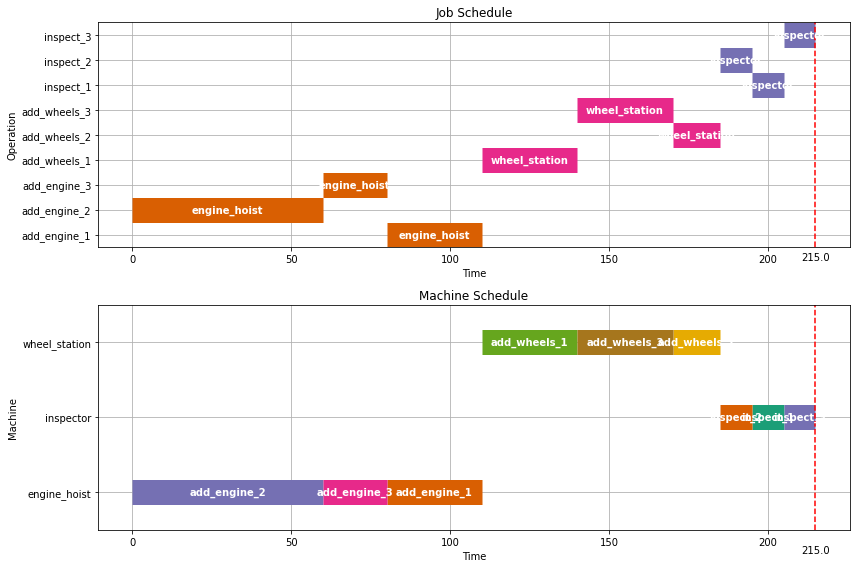

In [13]:
solution = Solution(job_shop)
solution.shuffle(3)

schedule = schedule_from_solution(job_shop, solution)
visualise(schedule)

Then, we run the local search (swapping the operations on the same machine) and obtain a much better schedule with a makespan of 135.

By comparing the two schedules, we can see that the following swaps have been done:

- On `engine_hoist`, swap `add_engine_2` and `add_engine_1`.
- On `inspector`, swap `inspect_2` and `inspect_3`.

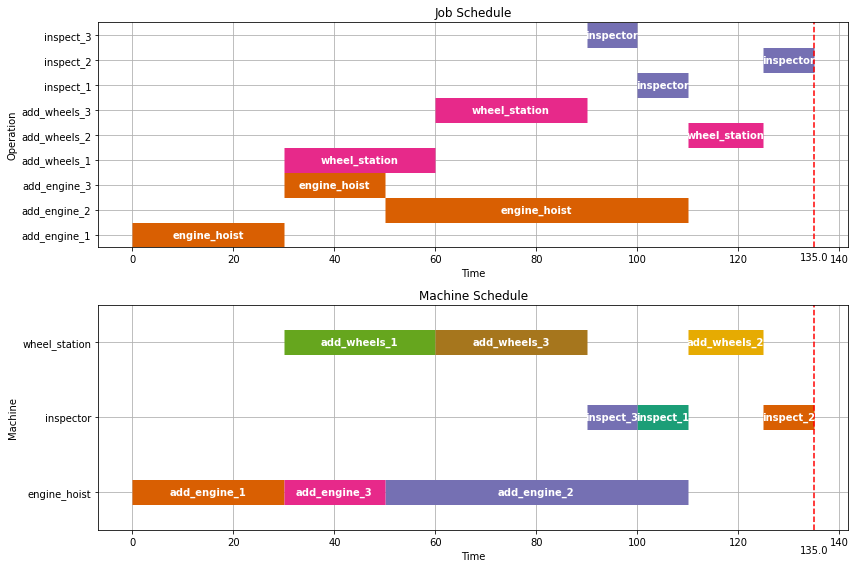

In [14]:
ls_schedule = local_search(solution, job_shop)
visualise(ls_schedule)

> Local search is easily stuck into local optima, thus its performance is very sensitive to the initial solution. To address this issue, we can use more advanced search techniques, such as simulated annealing, tabu search, genetic algorithms, to jump out of local optima and reach better solutions.

------------

The original Juypter Notebook can be downloaded [here](https://homepages.ecs.vuw.ac.nz/~yimei/tutorials/job-shop-scheduling-heuristics.ipynb).

More tutorials can be found [here](https://meiyi1986.github.io/tutorials/).

[Yi Mei's homepage](https://meiyi1986.github.io/)